In [1]:
import os, random
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

In [2]:
config = {
    "dataset_path": "images/",
    "validation_ratio": 0.2,
    "image_size": (300, 300),
    "input_shape": (300, 300, 3),
    "batch_size": 32,
    "mode": "train",
    "loss_function": "categorical_crossentropy",
    "optimizer": "adam",
    "epochs": 8,
    "dropout": 0.0,
    "backbone_train": False,
    "checkpoint_pattern": "checkpoint/vgg16/cp-{epoch:03d}.ckpt",
}

# train/test 데이터셋 나누기

In [3]:
from prep_image.loader import image_loader

# 전처리 과정 정의

In [4]:
from prep_image.preprocess import preprocess
from prep_image.preprocess import normalizer

# 모델 정의하기

In [5]:
def create_model(config):
    print('system >> creating a model...')
    model = define_model(config)
    mode = config['mode']

    if mode in ["retrain", "test"]:
        print('system >> loading pretrained model...', config['saved_model'])
        model.load_weights(config['saved_model'])
        
    model.compile(loss=config['loss_function'], optimizer=config['optimizer'], metrics=['accuracy'])
    return model

def define_model(config):
    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable = config["backbone_train"]
    
    classifier = ks.models.Sequential([
        layers.Flatten(),
        layers.Dropout(config['dropout']),
        layers.Dense(200, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    
    model = ks.models.Sequential([
        normalizer(config['input_shape']),
        vgg16,
        classifier
    ])
    return model

# 콜백 작성하기

In [6]:
class CustomCallback(ks.callbacks.Callback):

    def __init__(self):
        self.t_loss = {}
        self.t_acc = {}
        self.v_loss = {}
        self.v_acc = {}
        self.step = 0

    def on_epoch_end(self, epoch, logs):
        self.v_loss[self.step] = logs['val_loss']
        self.v_acc[self.step] = logs['val_accuracy']
        
    def on_train_batch_end(self, batch, logs=None):
        self.t_acc[self.step] = logs['accuracy']
        self.t_loss[self.step] = logs['loss']
        self.step += 1

    def on_train_end(self, logs):
        import matplotlib.pyplot as plt
        fig, (loss_ax, acc_ax) = plt.subplots(2, 1)
        
        loss_ax.plot(self.t_loss.keys(), self.t_loss.values(), label='training loss')
        loss_ax.plot(self.v_loss.keys(), self.v_loss.values(), label='validation loss')
        loss_ax.set_xlabel('Steps')
        loss_ax.set_ylabel('Loss')
        
        acc_ax.plot(self.t_acc.keys(), self.t_acc.values(), label='training acc')
        acc_ax.plot(self.v_acc.keys(), self.v_acc.values(), label='validation acc')
        acc_ax.set_xlabel('Steps')
        acc_ax.set_ylabel('Accuracy')
        
        plt.show()
        
recorder = CustomCallback()
checkpoint_callback = ks.callbacks.ModelCheckpoint(
    filepath=config["checkpoint_pattern"], 
    verbose=1,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    save_freq='epoch'
)

# 학습과 테스트 정의하기

In [7]:
def main(config):
    model = create_model(config)
    print('system >> model summary')
    model.summary()
    
    if config['mode'] in ['train', 'retrain']:
        hist = do_train(model, config)
        do_eval(model, config)
    else:
        do_eval(model, config)
        
    return hist

def do_train(model, config):
    shape = (config['batch_size'], *config['input_shape'])
    train_ds, valid_ds = image_loader(config['dataset_path'], config['validation_ratio'], 
                                  config['image_size'], config['batch_size'])
    print('system >> identified classes:', *train_ds.class_names)
    
    train_ds = preprocess(train_ds, shape=shape, shuffle=True, augment=True)
    valid_ds = preprocess(valid_ds, shape=shape)
    print('system >> training begins...')
    return model.fit(train_ds, 
          validation_data=valid_ds, 
          epochs=config['epochs'],
          callbacks=[recorder, checkpoint_callback])

def do_eval(model, config):
    shape = (config['batch_size'], *config['image_size'])
    valid_ds = image_loader(config['dataset_path'], config['validation_ratio'], 
                                  config['image_size'], config['batch_size'], subset='valid')
    print('system >> identified classes:', *valid_ds.class_names)
    
    valid_ds = preprocess(valid_ds, shape=shape)
    print('system >> evaluation begins...')
    model.evaluate(valid_ds)

def do_test(model, config):
    print('system >> test begins...')

system >> creating a model...
system >> model summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 8295203   
Total params: 23,009,891
Trainable params: 8,295,203
Non-trainable params: 14,714,688
_________________________________________________________________
Found 45000 files belonging to 3 classes.
Using 36000 files for training.
Found 45000 files belonging to 3 classes.
Using 9000 files for validation.
system >> identified classes: 0food 1interior 2exterior
system >> training begins...
Epoch 1/8
1125/1125 [==============================] - 284s 172ms/step - los

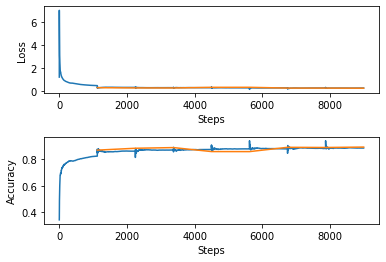

Found 45000 files belonging to 3 classes.
Using 9000 files for validation.
system >> identified classes: 0food 1interior 2exterior
system >> evaluation begins...
282/282 [==============================] - 52s 184ms/step - loss: 0.2482 - accuracy: 0.9010


In [8]:
main(config)

In [9]:
def on_train_end(self, cb):
        import matplotlib.pyplot as plt
        plt.plot(self.t_loss.keys(), self.t_loss.values())
        plt.xlabel('Training Steps')
        plt.ylabel('Training Loss')
        plt.show()

        self.t_loss = {}
        self.t_acc = {}